### Fitting a GMM to approximate posterior distributions.

---

In approxposterior, we fit build a GMM model to approximate the joint posterior distribution inferred by emcee.  We use sklearn's GMM implementation (https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and select the optimal number of components using the BIC. This notebook demonstrates this procedure.

In [1]:
%matplotlib inline

from __future__ import (print_function, division, absolute_import,
                        unicode_literals)
from approxposterior import gmmUtils
import numpy as np
from scipy import linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First, let's generate a disjoint bimodal Gaussian distribution (2 components).

In [2]:
np.random.seed(42)

# Spherical gaussian centered on (5, 10)
shiftG = np.random.randn(500, 2) + np.array([5, 10])

# Save mean
muShiftG = np.mean(shiftG, axis=0)

# Zero centered Gaussian data
c = np.array([[0., -0.7], [3.5, .7]])
stretchG = np.dot(np.random.randn(300, 2), c)

# Save mean
muStetchG = np.mean(stretchG, axis=0)

# Combine dataset, randomize points
data = np.vstack([shiftG, stretchG])
np.random.shuffle(data)

What does it look like?

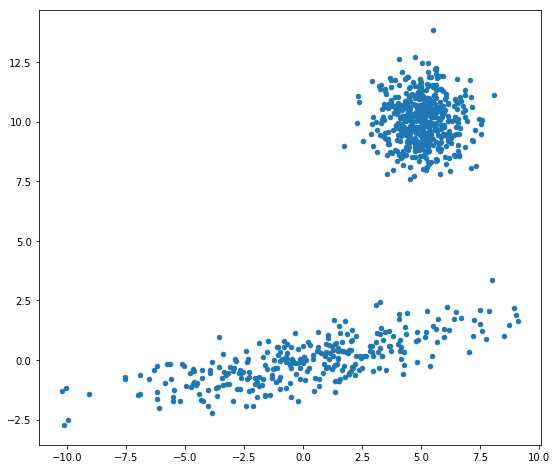

In [3]:
fig, ax = plt.subplots(figsize=(9,8))

ax.scatter(data[:,0], data[:,1], s=20)

Let's fit a GMM model to approximate the true density.  Clearly, there are two Gaussian components, but here we'll explore GMMs with up to 10 components to demonstrate how we can use the BIC (https://en.wikipedia.org/wiki/Bayesian_information_criterion) within fitGMM to select the optimal number of components, given the data.

In [4]:
# Fit!
gmm = gmmUtils.fitGMM(data, iburn=0, maxComp=10, covType="full")

Let's plot the data and our fit to see how we did.

Code based on https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py example.

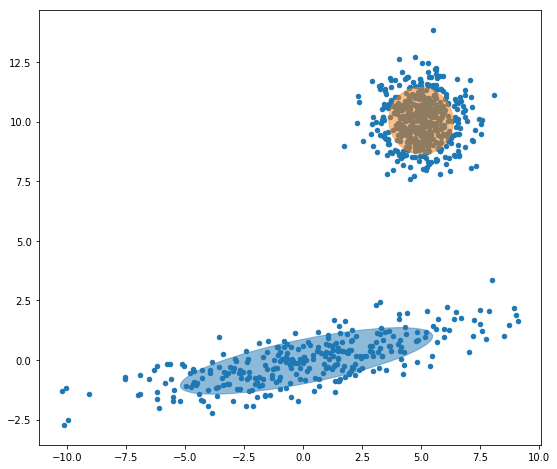

In [5]:
fig, ax = plt.subplots(figsize=(9,8))

# Plot data
ax.scatter(data[:,0], data[:,1], s=20)

# Now plot GMM components
colors = ["C%d" % ii for ii in range(len(gmm.means_))]
for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):
    v, w = linalg.eigh(cov)
    
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.5)
    ax.add_artist(ell)

Looks good!

Let's compare the true means with the inferred means.

In [6]:
print("Component 0 true, inferred:",muStetchG, gmm.means_[0])
print("Component 1 true, inferred:",muShiftG, gmm.means_[1])

Component 0 true, inferred: [ 0.15545514 -0.04124897] [ 0.15545514 -0.04124897]
Component 1 true, inferred: [ 5.0036012  10.03506291] [ 5.0036012  10.03506291]


Perfect!